# Setup

In [44]:
import numpy as np
from agents_clean import Agent
from model_clean import Model
from hybrid_networks_clean import rewire_network, randomize_network_v2, create_hybrid_network
from tqdm import tqdm
import networkx as nx
import pandas as pd
import random
from datetime import datetime
import numbers
import opinionated
import matplotlib.pyplot as plt
plt.style.use("opinionated_rc")
import colormaps as cmaps  

# Load Networks

In [26]:
!pip install dill
import dill

# Use dill to deserialize the graph from a file
with open('data_proc/perceptron_graph_pre_1979.pkl', 'rb') as f:
    G_perceptron = dill.load(f)

print('\n')
print(G_perceptron.nodes(data=True))
print('\n')
# Create a mapping from node names to indexes
mapping = {node: index for index, node in enumerate(G_perceptron.nodes())}

# Relabel the nodes in the graph
G_perceptron_indexed = nx.relabel_nodes(G_perceptron, mapping)
print(G_perceptron_indexed.nodes(data=True))


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


[('https://openalex.org/A5076896748', {'authored_paper_count': 6, 'cited_count': 124, 'titles': ['The perceptron: A probabilistic model for information storage and organization in the brain.', 'PRINCIPLES OF NEURODYNAMICS. PERCEPTRONS AND THE THEORY OF BRAIN MECHANISMS', 'Analysis of a Four-Layer Series-Coupled Perceptron. II', 'The perceptron: A probabilistic model for information storage and organization in the brain.', 'Perceptron Simulation Experiments', 'PRINCIPLES OF NEURODYNAMICS. PERCEPTRONS AND THE THEORY OF BRAIN MECHANISMS', 'Perceptron Simulation Experiments', 'The perceptron: A probabilistic model for information storage and organization in the brain.', 'PRINCIPLES OF NEURODYNAMICS. PERCEPTRONS AND THE THEORY OF BRAIN MECHANISMS', 'PRINCIPLES OF NEURODYNAMICS. PERCEPTRONS AND THE THEORY OF BRAIN MECHANISMS', 'Analysis of a Four-Layer Series-Coupled Perceptron. I

# Generate Parameters

In [27]:
def generate_parameters_empir(n,G,rewiring_type='hierarchical'):
    params_list = []
    #print('Generating parameters...')
    for _ in tqdm(range(n),desc="Generating parameters"):
        n_agents = random.randint(10, 500)
        #ba_degree = random.randint(1, int(n_agents/10))
        #er_prob=random.uniform(0, 0.3)
        p_rewiring = random.uniform(0, 1)
        if rewiring_type=='hierarchical':
            #G_er = nx.gnp_random_graph(n_agents, er_prob, directed=True)
            network = rewire_network(G, p_rewiring=p_rewiring)
        if rewiring_type=='randomize':
            #G_ba = nx.barabasi_albert_graph(n_agents, ba_degree)
            network = randomize_network_v2(G, p_rewiring=p_rewiring)
        # Calculate the mean degree of each node
        degrees = dict(network.degree())
        mean_degree = sum(degrees.values()) / len(degrees)
        uncertainty = random.uniform(0.001,0.01)
        n_experiments = random.randint(1, 1000)
        params = {
            "n_agents": n_agents,
            #"ba_degree": ba_degree,
            #"er_prob":er_prob,
            "p_rewiring": p_rewiring,
            "network": network,
            "uncertainty": uncertainty,
            "n_experiments": n_experiments,
            "rewiring_type":rewiring_type,
            'mean_degree':mean_degree
        }
        params_list.append(params)
    return params_list

In [29]:
# Example usage
parameter_dictionaries = generate_parameters_empir(2,G_perceptron_indexed,rewiring_type='randomize')  # Generate parameter dictionaries
parameter_dictionaries

Generating parameters: 100%|██████████| 2/2 [00:00<00:00, 13.82it/s]


[{'n_agents': 497,
  'p_rewiring': 0.9959274425470852,
  'network': <networkx.classes.digraph.DiGraph at 0x7feb25fecdc0>,
  'uncertainty': 0.009293456289478055,
  'n_experiments': 264,
  'rewiring_type': 'randomize',
  'mean_degree': 4.346689400397841},
 {'n_agents': 444,
  'p_rewiring': 0.981677108289375,
  'network': <networkx.classes.digraph.DiGraph at 0x7feb25fef010>,
  'uncertainty': 0.0013156368676480836,
  'n_experiments': 940,
  'rewiring_type': 'randomize',
  'mean_degree': 4.346121057118499}]

# Simulation Functions

In [30]:
def run_simulation_with_params(param_dict, number_of_steps=200, agent_type="bayes"):
    # Extract the network directly since it's already a NetworkX graph object
    my_network = param_dict['network']
    #agent_type = param_dict['agent_type']
    # Other parameters are directly extracted from the dictionary
    my_model = Model(my_network, n_experiments=param_dict['n_experiments'], uncertainty=param_dict['uncertainty']
                    , agent_type=agent_type)
    # Run the simulation with predefined steps and show_bar option
    
    my_model.run_simulation(number_of_steps=number_of_steps, show_bar=False)
  
    

    result_dict = {
        key: value 
        for key, value in param_dict.items() 
        if isinstance(value, (numbers.Number, str, tuple, list))}   
    result_dict['true_consensus'] = my_model.conclusion
    result_dict['true_consensus_alternative_stop'] = my_model.conclusion_alternative_stop
    df = pd.DataFrame(my_model.agents_choices) 
    result_dict['choice_consensus'] = df.mean()[len(df.mean())-1]
    result_dict['convergence_step'] = my_model.n_steps # takes note of the last reported step
    result_dict['agent_type']=agent_type
    
    return result_dict


def run_simulations(param_list, number_of_steps=1000,agent_type="bayes"):
    def run_simulation(param_dict):
        return run_simulation_with_params(param_dict, number_of_steps=number_of_steps, agent_type=agent_type)
    
    results = []
    # Iterate over each parameter dictionary in the list
    for params in tqdm(param_list, desc="Running simulations"):
        result = run_simulation(params)
        results.append(result)
    
    # Convert the list of results into a Pandas DataFrame
    results_df = pd.DataFrame(results)
    return results_df

# Run Simulations

In [31]:
# Test Simulation
parameter_dictionaries = generate_parameters_empir(2,G_perceptron_indexed,rewiring_type='randomize')  # Generate parameter dictionaries
#print(parameter_dictionaries)
test_results_df = run_simulations(parameter_dictionaries, number_of_steps=200, agent_type="bayes")
test_results_df.to_csv('test_results_df.csv', index=False)
test_results_df.head()

Running simulations: 100%|██████████| 2/2 [00:07<00:00,  3.56s/it]


,n_agents,p_rewiring,uncertainty,n_experiments,rewiring_type,mean_degree,true_consensus,true_consensus_alternative_stop,choice_consensus,convergence_step,agent_type
0,223,0.285715,0.004556,498,randomize,4.346121,0.585678,False,0.585678,200,bayes
1,327,0.170546,0.007370,729,randomize,4.346689,0.545041,0.545041,0.545041,125,bayes


In [46]:
# Bayes Agent
do_initial_simulation = False
if do_initial_simulation:
    n_sims = 2 # this is for each type of rewiring
    bayes_results_df = pd.DataFrame(columns=test_results_df.columns)
    for rewiring_type in ['hierarchical','randomize']:
        parameter_dictionaries = generate_parameters_empir(n_sims,G_perceptron_indexed,rewiring_type=rewiring_type)  # Generate parameter dictionaries
        results_df1 = run_simulations(parameter_dictionaries, number_of_steps=200, agent_type="bayes")
        bayes_results_df = pd.concat([bayes_results_df, results_df1], ignore_index=True)
        
    bayes_results_df.to_csv('bayesagent_empiricalnetworks_results_df.csv', index=False)

saved_bayes_results_df = pd.read_csv('bayesagent_empiricalnetworks_results_df.csv')

add_simulations = True
if add_simulations:
    n_sims = 200 # this is for each type of rewiring
    bayes_results_df = pd.DataFrame(columns=test_results_df.columns)
    for rewiring_type in ['hierarchical','randomize']:
        parameter_dictionaries = generate_parameters_empir(n_sims,G_perceptron_indexed,rewiring_type=rewiring_type)  # Generate parameter dictionaries
        results_df1 = run_simulations(parameter_dictionaries, number_of_steps=200, agent_type="bayes")
        bayes_results_df = pd.concat([bayes_results_df, results_df1], ignore_index=True)
    bayes_results_df = pd.concat([saved_bayes_results_df, bayes_results_df], ignore_index=True)
    bayes_results_df.to_csv('bayesagent_empiricalnetworks_results_df.csv', index=False)
else: 
    bayes_results_df=saved_bayes_results_df

print(datetime.now())
    
bayes_results_df.info()

Generating parameters:   0%|          | 0/200 [00:00<?, ?it/s]

Generating parameters:   0%|          | 1/200 [00:35<1:58:23, 35.69s/it]

In [ ]:
# Beta Agent
do_initial_simulation = False
if do_initial_simulation:
    n_sims = 1
    beta_results_df = pd.DataFrame(columns=test_results_df.columns)
    for rewiring_type in ['hierarchical','randomize']:
        parameter_dictionaries = generate_parameters_empir(n_sims,G_perceptron_indexed,rewiring_type=rewiring_type)  # Generate parameter dictionaries
        results_df1 = run_simulations(parameter_dictionaries, number_of_steps=200, agent_type="beta")
        beta_results_df = pd.concat([beta_results_df, results_df1], ignore_index=True)
        
    beta_results_df.to_csv('betasagent_empiricalnetworks_results_df.csv', index=False)

saved_beta_results_df = pd.read_csv('betasagent_empiricalnetworks_results_df.csv')

add_simulations = True
if add_simulations:
    n_sims =  23# this is for each type of rewiring
    beta_results_df = pd.DataFrame(columns=test_results_df.columns)
    for rewiring_type in ['hierarchical','randomize']:
        parameter_dictionaries = generate_parameters_empir(n_sims,G_perceptron_indexed,rewiring_type=rewiring_type)  # Generate parameter dictionaries
        results_df1 = run_simulations(parameter_dictionaries, number_of_steps=200, agent_type="beta")
        beta_results_df = pd.concat([beta_results_df, results_df1], ignore_index=True)
        
    beta_results_df = pd.concat([saved_beta_results_df, beta_results_df], ignore_index=True)
    beta_results_df.to_csv('betasagent_empiricalnetworks_results_df.csv', index=False)
else:
    beta_results_df = saved_beta_results_df
    
print(datetime.now())

beta_results_df.info()

Generating parameters:   0%|          | 0/100 [00:00<?, ?it/s]

Running simulations: 100%|██████████| 100/100 [2:17:45<00:00, 82.66s/it] 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 11 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   n_agents                         204 non-null    object 
 1   p_rewiring                       204 non-null    float64
 2   uncertainty                      204 non-null    float64
 3   n_experiments                    204 non-null    object 
 4   rewiring_type                    204 non-null    object 
 5   mean_degree                      204 non-null    float64
 6   true_consensus                   204 non-null    float64
 7   true_consensus_alternative_stop  204 non-null    object 
 8   choice_consensus                 204 non-null    float64
 9   convergence_step                 204 non-null    object 
 10  agent_type                       204 non-null    object 
dtypes: float64(5), object(6)
memory usage: 17.7+ KB


2024-06-11 09:57:38.542292


# Now Some Plotting

## Basic Plotting

In [41]:
def plot_results(results_df=bayes_results_df,variable_of_interest = 'true_consensus',regressor = 'n_agents'):
    grouped = results_df.groupby(['rewiring_type', regressor])[variable_of_interest].mean().reset_index()

    # Preparing for the line plot
    #grouped['mid_bin'] = grouped['binned'].apply(lambda x: x.mid).astype(float)  # Getting the midpoint of bins for plotting

    # Plotting
    plt.figure(figsize=(10, 8))

    for rewiring_type in results_df['rewiring_type'].unique():
        subset = grouped[grouped['rewiring_type'] == rewiring_type]
        plt.plot(subset[regressor], subset[variable_of_interest], marker='o', label=rewiring_type)

    plt.xlabel(regressor)
    plt.ylabel('Share of '+variable_of_interest)
    plt.title('Share of '+ variable_of_interest +' by ' + regressor)
    opinionated.add_legend(title='rewiring_type')

    plt.grid(True)
    plt.show()

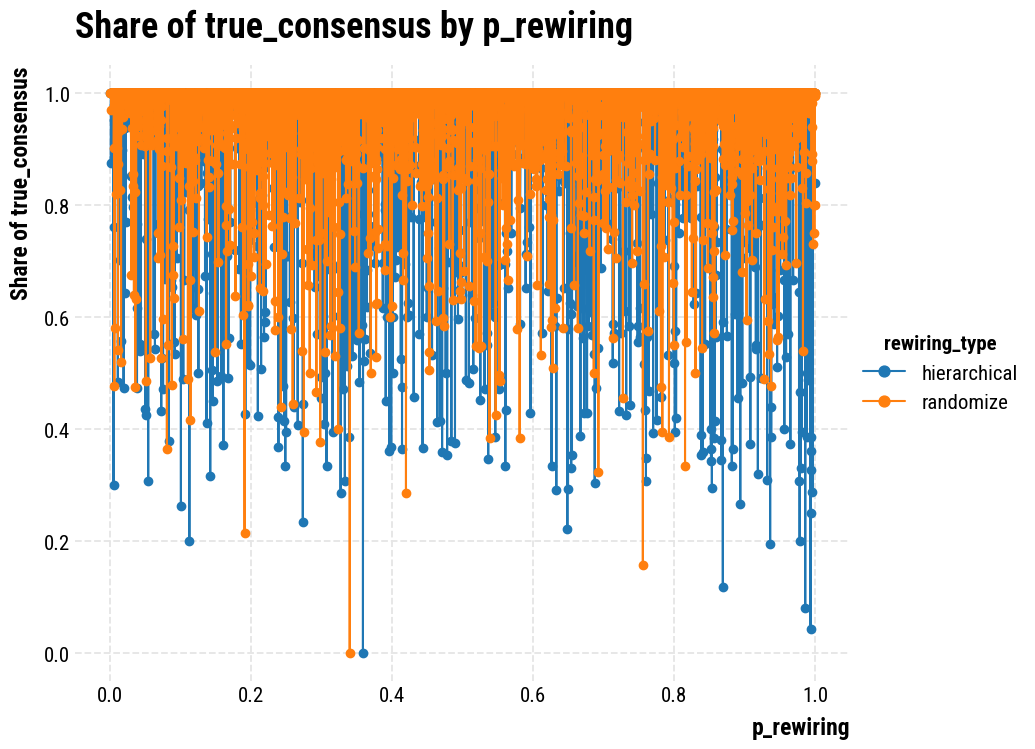

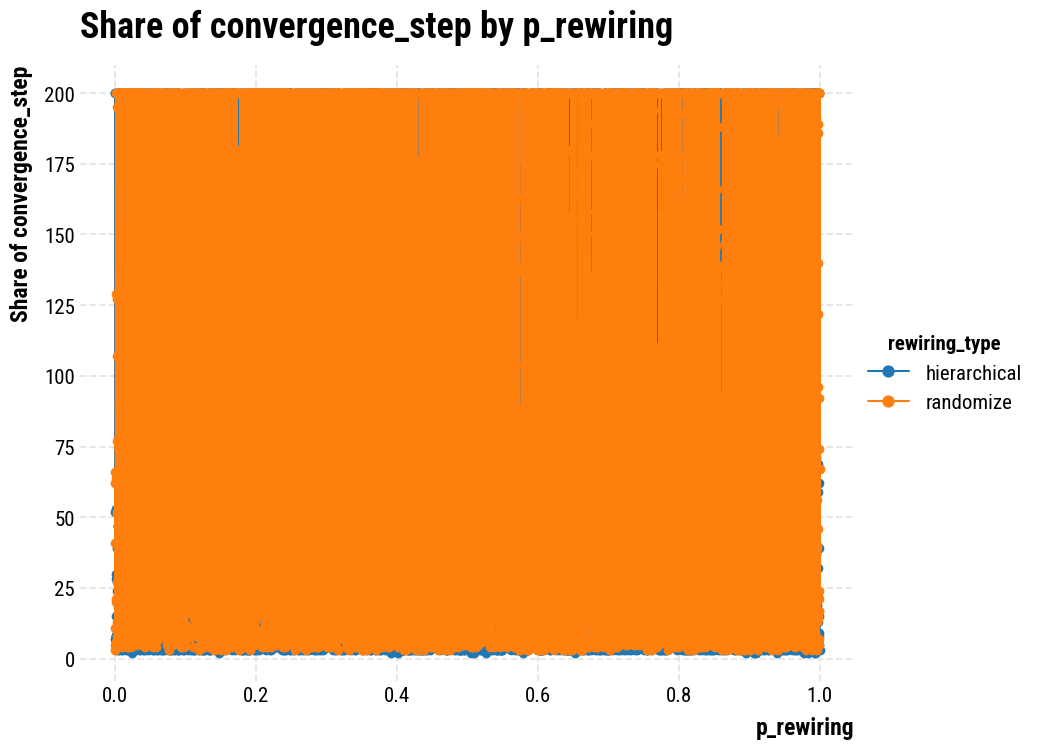

In [43]:
plot_results(bayes_results_df,variable_of_interest = 'true_consensus',regressor = 'p_rewiring')
plot_results(bayes_results_df,variable_of_interest = 'convergence_step',regressor = 'p_rewiring')

# More Advanced Plotting

In [44]:
from pygam import LogisticGAM, s
from sklearn.model_selection import train_test_split

ModuleNotFoundError: No module named 'pygam'

In [19]:
bayes_results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1060 entries, 0 to 1059
Data columns (total 13 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   n_agents                         1060 non-null   object 
 1   ba_degree                        1060 non-null   object 
 2   er_prob                          1060 non-null   float64
 3   p_rewiring                       1060 non-null   float64
 4   uncertainty                      1060 non-null   float64
 5   n_experiments                    1060 non-null   object 
 6   rewiring_type                    1060 non-null   object 
 7   mean_degree                      1060 non-null   float64
 8   true_consensus                   1060 non-null   float64
 9   true_consensus_alternative_stop  1060 non-null   object 
 10  choice_consensus                 1060 non-null   float64
 11  convergence_step                 1060 non-null   object 
 12  agent_type          

## First Just on Number of Agents

In [20]:
def do_regression(results_df=bayes_results_df,variable_of_interest = 'true_consensus'):
    # Splitting the DataFrame by network type
    network_types = results_df['rewiring_type'].unique()

    my_gams = {}

    for network_type in network_types:
        # Subset the DataFrame by network type
        subset = results_df[results_df['rewiring_type'] == network_type]
        
        # Preparing the data
        X = subset[['n_agents','uncertainty','p_rewiring','mean_degree']]
        y = subset[variable_of_interest]#.astype(int)  # Convert boolean to integer
        
        # Splitting the data into training and testing sets for model validation
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        
        # Fitting the Logistic GAM model
        gam = LogisticGAM(s(0,n_splines=6)).fit(X_train, y_train)
        
        # Storing the model
        my_gams[network_type] = gam
        
        # Optionally, you can print out model accuracy or other statistics here
        print(f"Model for {network_type}:")
        print(f"Accuracy on training data: {gam.accuracy(X_train, y_train)}")
        print(f"Accuracy on test data: {gam.accuracy(X_test, y_test)}")
        print("-" * 30)
        
    return my_gams,X

do_regression()

Model for hierarchical:
Accuracy on training data: 0.8301886792452831
Accuracy on test data: 0.7861635220125787
------------------------------
Model for randomize:
Accuracy on training data: 0.7547169811320755
Accuracy on test data: 0.7044025157232704
------------------------------


/Users/ignacioojea/anaconda3/lib/python3.10/site-packages/pygam/pygam.py:1151: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden'] = full_ll / null_ll
/Users/ignacioojea/anaconda3/lib/python3.10/site-packages/pygam/pygam.py:1152: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden_adj'] = 1.0 - (full_ll - self.statistics_['edof']) / null_ll
/Users/ignacioojea/anaconda3/lib/python3.10/site-packages/pygam/pygam.py:1151: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden'] = full_ll / null_ll
/Users/ignacioojea/anaconda3/lib/python3.10/site-packages/pygam/pygam.py:1152: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden_adj'] = 1.0 - (full_ll - self.statistics_['edof']) / null_ll


({'hierarchical': LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
     fit_intercept=True, max_iter=100, terms=s(0) + intercept, 
     tol=0.0001, verbose=False),
  'randomize': LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
     fit_intercept=True, max_iter=100, terms=s(0) + intercept, 
     tol=0.0001, verbose=False)},
      n_agents  uncertainty  p_rewiring  mean_degree
 10        115     0.009738    0.867927     9.391304
 11        302     0.007404    0.215158    11.688742
 12        238     0.001524    0.231605    18.857143
 13         51     0.005738    0.375522     3.686275
 14         34     0.007960    0.430805     5.235294
 ...       ...          ...         ...          ...
 1055      275     0.008866    0.145741     5.912727
 1056      366     0.001473    0.826891    61.311475
 1057      120     0.003437    0.197620    18.016667
 1058      291     0.006569    0.159598    41.498282
 1059      443     0.006120    0.675676    26.492099
 
 [530 rows x 4 col

In [21]:
def do_regression(results_df=bayes_results_df,variable_of_interest = 'true_consensus'):
    # Splitting the DataFrame by network type
    network_types = results_df['rewiring_type'].unique()

    my_gams = {}

    for network_type in network_types:
        # Subset the DataFrame by network type
        subset = results_df[results_df['rewiring_type'] == network_type]
        
        # Preparing the data
        X = subset[['n_agents','uncertainty','p_rewiring','mean_degree']]
        y = subset[variable_of_interest]#.astype(int)  # Convert boolean to integer
        
        # Splitting the data into training and testing sets for model validation
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        
        # Fitting the Logistic GAM model
        gam = LogisticGAM(s(0,n_splines=6)).fit(X_train, y_train)
        
        # Storing the model
        my_gams[network_type] = gam
        
        # Optionally, you can print out model accuracy or other statistics here
        print(f"Model for {network_type}:")
        print(f"Accuracy on training data: {gam.accuracy(X_train, y_train)}")
        print(f"Accuracy on test data: {gam.accuracy(X_test, y_test)}")
        print("-" * 30)
        
    return my_gams,X

do_regression()

Model for hierarchical:
Accuracy on training data: 0.8301886792452831
Accuracy on test data: 0.7861635220125787
------------------------------
Model for randomize:
Accuracy on training data: 0.7547169811320755
Accuracy on test data: 0.7044025157232704
------------------------------


/Users/ignacioojea/anaconda3/lib/python3.10/site-packages/pygam/pygam.py:1151: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden'] = full_ll / null_ll
/Users/ignacioojea/anaconda3/lib/python3.10/site-packages/pygam/pygam.py:1152: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden_adj'] = 1.0 - (full_ll - self.statistics_['edof']) / null_ll
/Users/ignacioojea/anaconda3/lib/python3.10/site-packages/pygam/pygam.py:1151: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden'] = full_ll / null_ll
/Users/ignacioojea/anaconda3/lib/python3.10/site-packages/pygam/pygam.py:1152: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden_adj'] = 1.0 - (full_ll - self.statistics_['edof']) / null_ll


({'hierarchical': LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
     fit_intercept=True, max_iter=100, terms=s(0) + intercept, 
     tol=0.0001, verbose=False),
  'randomize': LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
     fit_intercept=True, max_iter=100, terms=s(0) + intercept, 
     tol=0.0001, verbose=False)},
      n_agents  uncertainty  p_rewiring  mean_degree
 10        115     0.009738    0.867927     9.391304
 11        302     0.007404    0.215158    11.688742
 12        238     0.001524    0.231605    18.857143
 13         51     0.005738    0.375522     3.686275
 14         34     0.007960    0.430805     5.235294
 ...       ...          ...         ...          ...
 1055      275     0.008866    0.145741     5.912727
 1056      366     0.001473    0.826891    61.311475
 1057      120     0.003437    0.197620    18.016667
 1058      291     0.006569    0.159598    41.498282
 1059      443     0.006120    0.675676    26.492099
 
 [530 rows x 4 col

In [ ]:
X.head()

,n_agents,uncertainty,p_rewiring,mean_degree
10,142,0.007550,0.100761,23.281690
11,190,0.008980,0.756384,26.442105
12,44,0.002884,0.916358,1.863636
13,375,0.009186,0.710161,49.413333
14,80,0.006021,0.951762,13.600000


In [22]:
def plot_regression(results_df=bayes_results_df,variable_of_interest = 'true_consensus'):
    my_gams,X = do_regression(results_df=results_df,variable_of_interest = variable_of_interest)
    # Set the size of the figure
    plt.figure(figsize=(10, 6))

    cmap= cmaps.colorblind_10

    X_range = np.linspace(X['n_agents'].min(), X['n_agents'].max(), 100)

    colors =[cmap(0), cmap(1/cmap.N), cmap(1/cmap.N*2)]

    for i, (network_type, gam) in enumerate(my_gams.items()):
        conf = gam.confidence_intervals(X_range.reshape(-1, 1), width=0.95, quantiles=None)
        plt.fill_between(X_range, conf[:, 0], conf[:, 1], facecolor=colors[i], alpha=0.2, interpolate=True)


    for i, (network_type, gam) in enumerate(my_gams.items()):
        # Generating a range of values for n_agents to predict and plot
        # Predicting with the model
        #y_pred, conf = pdep, confi = model.partial_dependence(term=0, width=.95)
        y_pred = gam.predict_proba(X_range.reshape(-1, 1))

        # Plotting predicted probabilities
        plt.plot(X_range, y_pred,c=colors[i], label=f'{network_type}')
        
    # Adding title, labels, and legend
    plt.title('Effect of n_agents on '+ variable_of_interest +' Probability')
    plt.xlabel('Number of Agents')
    plt.ylabel('Probability of ' +variable_of_interest)
    plt.legend()
    plt.show()

In [23]:
plot_regression(bayes_results_df)

/Users/ignacioojea/anaconda3/lib/python3.10/site-packages/pygam/pygam.py:1151: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden'] = full_ll / null_ll
/Users/ignacioojea/anaconda3/lib/python3.10/site-packages/pygam/pygam.py:1152: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden_adj'] = 1.0 - (full_ll - self.statistics_['edof']) / null_ll
/Users/ignacioojea/anaconda3/lib/python3.10/site-packages/pygam/pygam.py:1151: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden'] = full_ll / null_ll
/Users/ignacioojea/anaconda3/lib/python3.10/site-packages/pygam/pygam.py:1152: RuntimeWarning: invalid value encountered in scalar divide
  r2['McFadden_adj'] = 1.0 - (full_ll - self.statistics_['edof']) / null_ll


Model for hierarchical:
Accuracy on training data: 0.8301886792452831
Accuracy on test data: 0.7861635220125787
------------------------------
Model for randomize:
Accuracy on training data: 0.7547169811320755
Accuracy on test data: 0.7044025157232704
------------------------------


ValueError: X data must have 4 features, but found 1

<Figure size 1000x600 with 0 Axes>

In [ ]:
plot_full(results_df=bayes_results_df,variable_of_interest = 'true_consensus')
plot_full(results_df=bayes_results_df,variable_of_interest = 'choice_consensus')
plot_full(results_df=bayes_results_df,variable_of_interest = 'convergence_step')

KeyError: "['degree'] not in index"